# Deep Kernel Learning with Lux

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/main/examples/2-deep-kernel-learning/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/2-deep-kernel-learning/).*

In [1]:
# Background

This example trains a GP whose inputs are passed through a neural network.
This kind of model has been considered previously [^Calandra] [^Wilson], although it has been shown that some care is needed to avoid substantial overfitting [^Ober].
In this example we make use of the `FunctionTransform` from [KernelFunctions.jl](github.com/JuliaGaussianProcesses/KernelFunctions.jl/) to put a simple Multi-Layer Perceptron built using Lux.jl inside a standard kernel.

[^Calandra]: Calandra, R., Peters, J., Rasmussen, C. E., & Deisenroth, M. P. (2016, July). [Manifold Gaussian processes for regression.](https://ieeexplore.ieee.org/abstract/document/7727626) In 2016 International Joint Conference on Neural Networks (IJCNN) (pp. 3338-3345). IEEE.

[^Wilson]: Wilson, A. G., Hu, Z., Salakhutdinov, R. R., & Xing, E. P. (2016). [Stochastic variational deep kernel learning.](https://proceedings.neurips.cc/paper/2016/hash/bcc0d400288793e8bdcd7c19a8ac0c2b-Abstract.html) Advances in Neural Information Processing Systems, 29.

[^Ober]: Ober, S. W., Rasmussen, C. E., & van der Wilk, M. (2021, December). [The promises and pitfalls of deep kernel learning.](https://proceedings.mlr.press/v161/ober21a.html) In Uncertainty in Artificial Intelligence (pp. 1206-1216). PMLR.

### Package loading
We use a couple of useful packages to plot and optimize
the different hyper-parameters

In [2]:
using AbstractGPs
using Distributions
using KernelFunctions
using LinearAlgebra
using Lux
using Optimisers
using Plots
using Random
using Zygote
default(; legendfontsize=15.0, linewidth=3.0);

Random.seed!(42)  # for reproducibility

Random.TaskLocalRNG()

## Data creation
We create a simple 1D Problem with very different variations

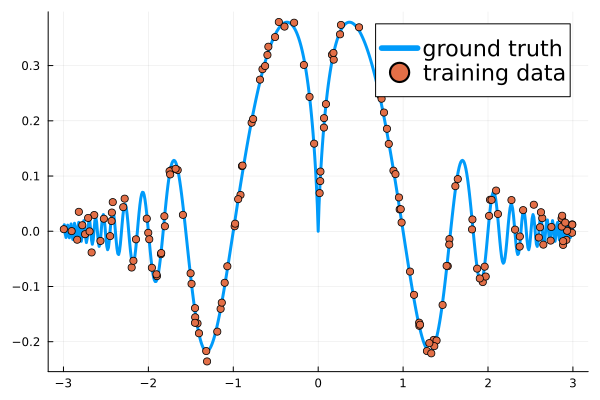

In [3]:
xmin, xmax = (-3, 3)  # Limits
N = 150
noise_std = 0.01
x_train_vec = rand(Uniform(xmin, xmax), N) # Training dataset
x_train = collect(eachrow(x_train_vec)) # vector-of-vectors for neural network compatibility
target_f(x) = sinc(abs(x)^abs(x)) # We use sinc with a highly varying value
y_train = target_f.(x_train_vec) + randn(N) * noise_std
x_test_vec = range(xmin, xmax; length=200) # Testing dataset
x_test = collect(eachrow(x_test_vec)) # vector-of-vectors for neural network compatibility

plot(xmin:0.01:xmax, target_f; label="ground truth")
scatter!(x_train_vec, y_train; label="training data")

## Model definition
We create a neural net with 2 layers and 10 units each.
The data is passed through the NN before being used in the kernel.

In [4]:
neuralnet = Chain(Dense(1 => 20), Dense(20 => 30), Dense(30 => 5))

Chain(
    layer_1 = Dense(1 => 20),                     # 40 parameters
    layer_2 = Dense(20 => 30),                    # 630 parameters
    layer_3 = Dense(30 => 5),                     # 155 parameters
)         # Total: 825 parameters,
          #        plus 0 states.

Initialize the neural network parameters

In [5]:
rng = Random.default_rng()
ps, st = Lux.setup(rng, neuralnet)

smodel = StatefulLuxLayer(neuralnet, ps, st)

StatefulLuxLayer{Val{true}()}(
    Chain(
        layer_1 = Dense(1 => 20),                 # 40 parameters
        layer_2 = Dense(20 => 30),                # 630 parameters
        layer_3 = Dense(30 => 5),                 # 155 parameters
    ),
)         # Total: 825 parameters,
          #        plus 0 states.

We use the Squared Exponential Kernel:

In [6]:
k = SqExponentialKernel() ∘ FunctionTransform(smodel)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: LuxCore.StatefulLuxLayerImpl.StatefulLuxLayer{Val{true}, Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}, layer_2::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}, layer_3::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.Tru

We now define our model:

In [7]:
gpprior = GP(k)  # GP Prior
fx = AbstractGPs.FiniteGP(gpprior, x_train, noise_std^2)  # Prior at the observations
fp = posterior(fx, y_train)  # Posterior of f given the observations

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Tuple{}}]). Converting to common type to to attempt to use BLAS. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/Kx6MR/src/impl/matmul.jl:194


AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{LuxCore.StatefulLuxLayerImpl.StatefulLuxLayer{Val{true}, Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}, layer_2::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}, layer_3::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}}, @NamedTuple{α::Vector{Float64}, C::LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, x::Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Sl

This computes the negative log evidence of `y` (the negative log marginal likelihood of
the neural network parameters), which is going to be used as the objective:

In [8]:
loss(y) = -logpdf(fx, y)

@info "Initial loss = $(loss(y_train))"

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Tuple{}}]). Converting to common type to to attempt to use BLAS. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/Kx6MR/src/impl/matmul.jl:194
[ Info: Initial loss = 1193.2798548789099


We show the initial prediction with the untrained model

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Tuple{}}]). Converting to common type to to attempt to use BLAS. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/Kx6MR/src/impl/matmul.jl:194


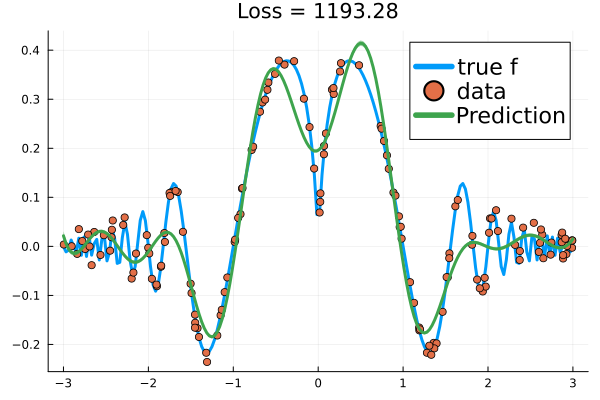

In [9]:
p_init = plot(; title="Loss = $(round(loss(y_train); sigdigits=6))")
plot!(vcat(x_test...), target_f; label="true f")
scatter!(vcat(x_train...), y_train; label="data")
pred_init = marginals(fp(x_test))
plot!(vcat(x_test...), mean.(pred_init); ribbon=std.(pred_init), label="Prediction")

## Training

In [10]:
nmax = 200

200

Create a wrapper function that updates the kernel with current parameters

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Tuple{}}]). Converting to common type to to attempt to use BLAS. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/Kx6MR/src/impl/matmul.jl:194
[ Info: iteration 10/200: loss = -203.62267425516478
[ Info: iteration 20/200: loss = -173.16968824598374
[ Info: iteration 30/200: loss = -175.46988005464902
[ Info: iteration 40/200: loss = -195.11599295773578
[ Info: iteration 50/200: loss = -203.1397284271295
[ Info: iteration 60/200: loss = -202.6245663170772
[ Info: iteration 70/200: loss = -203.77390824403147
[ Info: iteration 80/200: loss = -203.81538365192796
[ Info: iteration 90/200: loss = -203.90627381120248
[ Info: iteration 100/200: loss = -203.94627828471977
[ Info: iteration 110/200: loss = -20

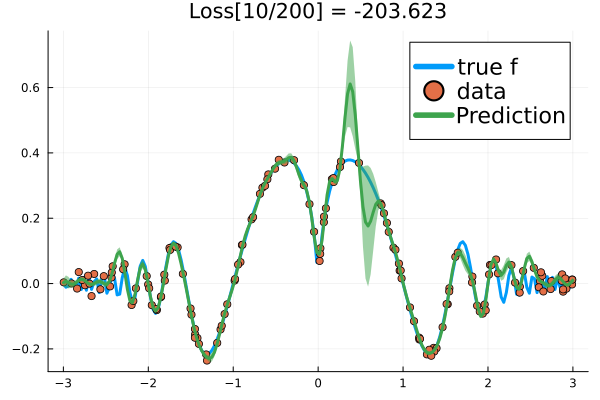

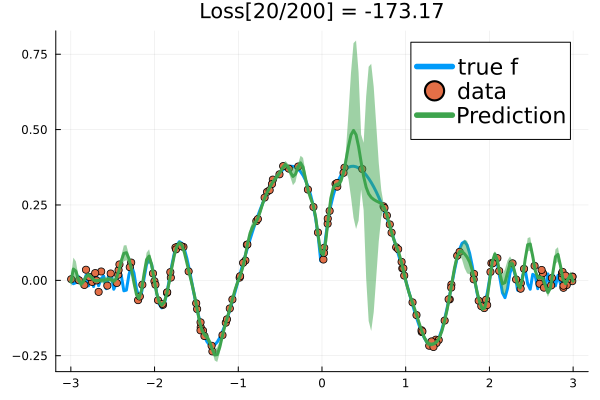

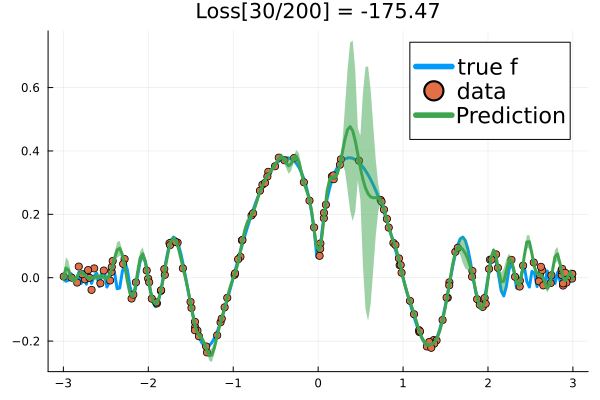

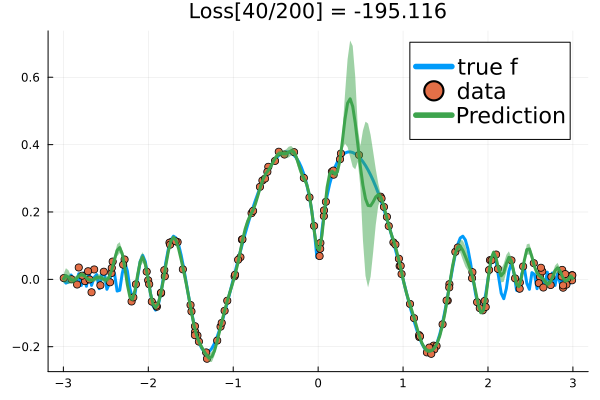

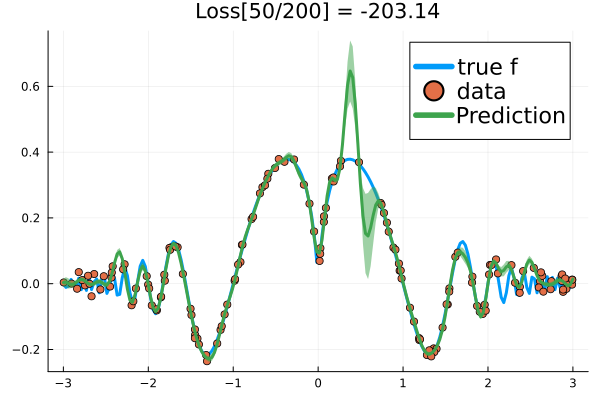

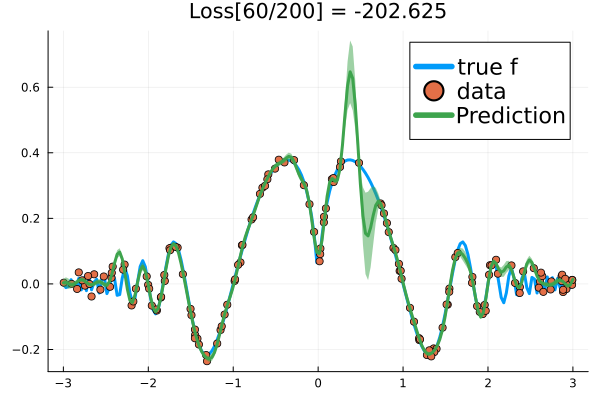

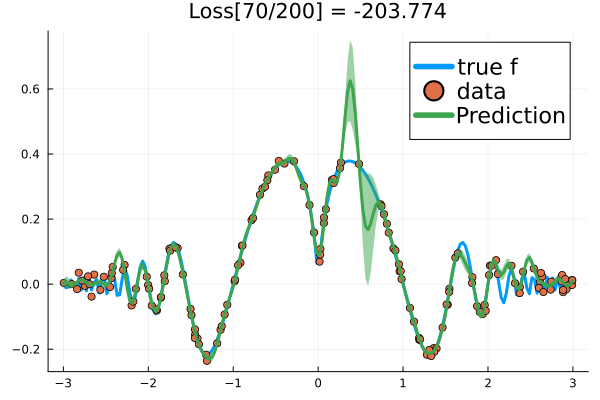

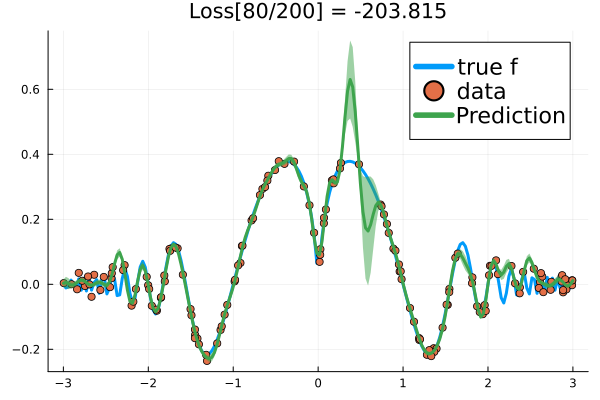

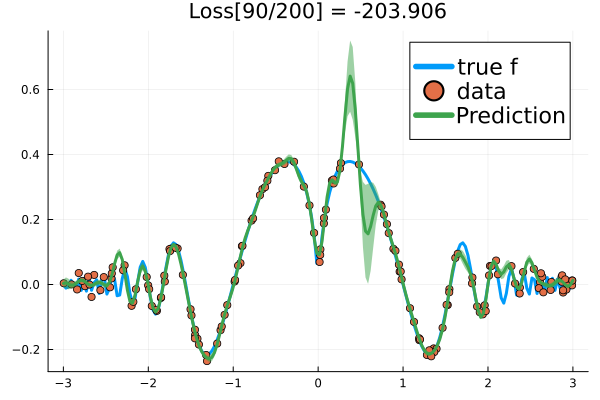

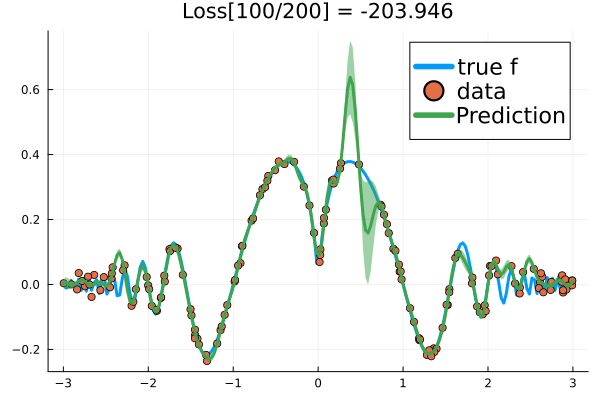

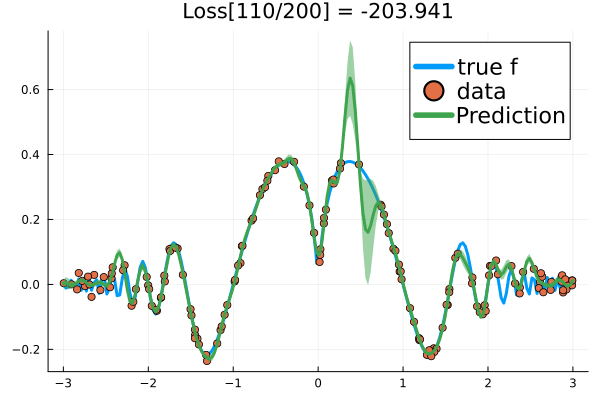

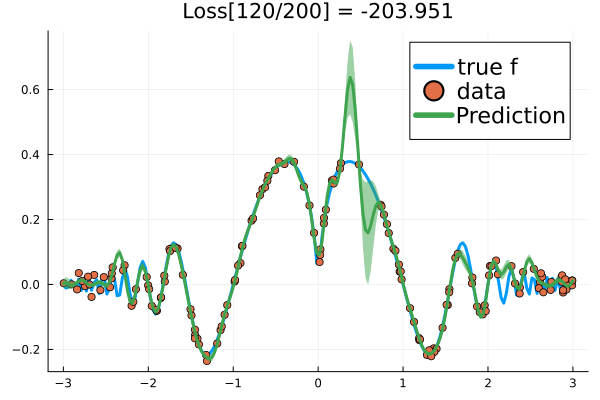

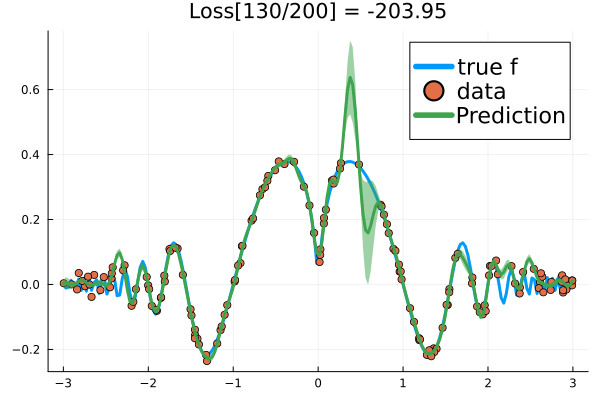

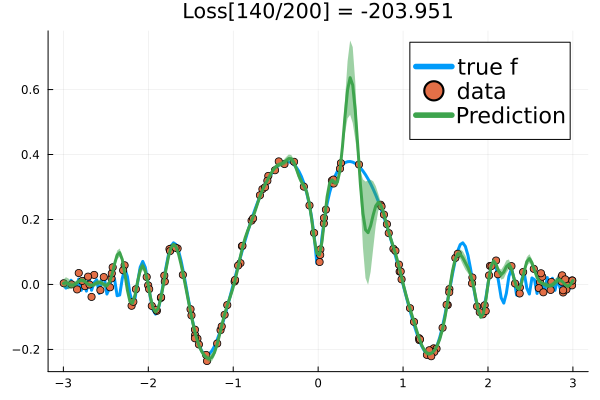

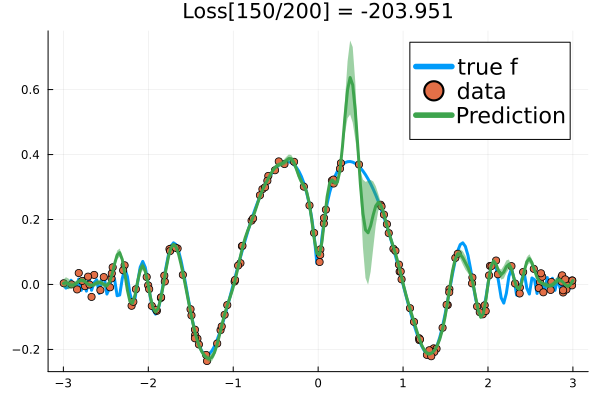

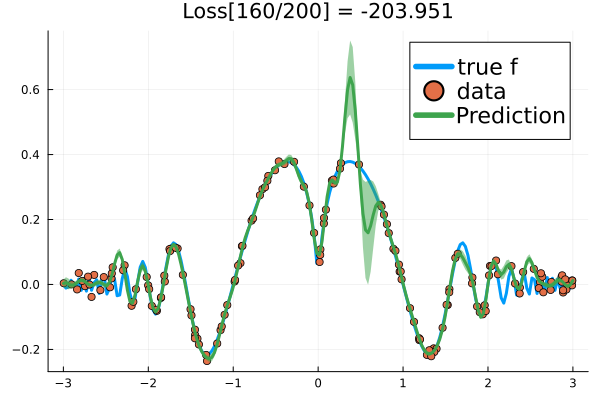

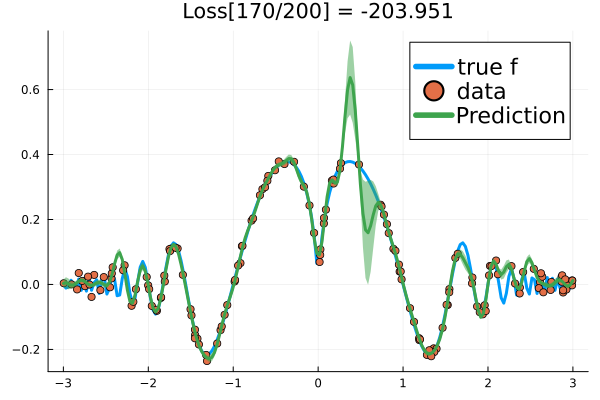

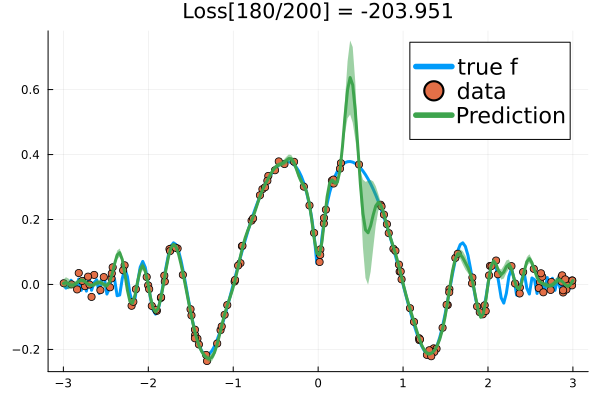

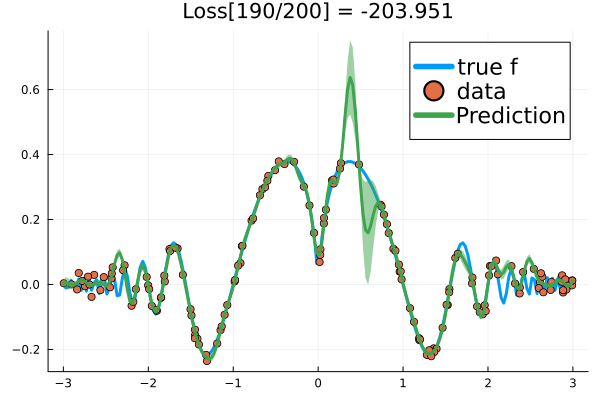

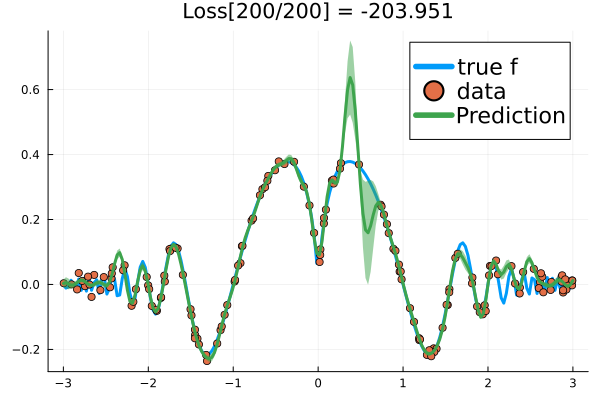

In [11]:
function update_kernel_and_loss(model, ps, st, data)
    smodel = StatefulLuxLayer(model, ps, st)
    k_updated = SqExponentialKernel() ∘ FunctionTransform(smodel)
    fx_updated = AbstractGPs.FiniteGP(GP(k_updated), x_train, noise_std^2)
    return -logpdf(fx_updated, y_train), smodel.st, (;)
end

anim = Animation()
let tstate = Training.TrainState(neuralnet, ps, st, Optimisers.Adam(0.005))
    for i in 1:nmax
        _, loss_val, _, tstate = Training.single_train_step!(
            AutoZygote(), update_kernel_and_loss, (), tstate
        )

        if i % 10 == 0
            k =
                SqExponentialKernel() ∘ FunctionTransform(
                    StatefulLuxLayer(neuralnet, tstate.parameters, tstate.states)
                )
            fx = AbstractGPs.FiniteGP(GP(k), x_train, noise_std^2)

            @info "iteration $i/$nmax: loss = $loss_val"

            p = plot(; title="Loss[$i/$nmax] = $(round(loss_val; sigdigits=6))")
            plot!(vcat(x_test...), target_f; label="true f")
            scatter!(vcat(x_train...), y_train; label="data")
            pred = marginals(posterior(fx, y_train)(x_test))
            plot!(vcat(x_test...), mean.(pred); ribbon=std.(pred), label="Prediction")
            frame(anim)
            display(p)
        end
    end
end

gif(anim, "train-dkl.gif"; fps=3)
nothing #hide

![](train-dkl.gif)
<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/AbstractGPs.jl/AbstractGPs.jl/examples/2-deep-kernel-learning/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.24 &#96;/home/runner/work/AbstractGPs.jl/AbstractGPs.jl#ef3edc2&#96;
  &#91;31c24e10&#93; Distributions v0.25.120
  &#91;ec8451be&#93; KernelFunctions v0.10.65
  &#91;98b081ad&#93; Literate v2.20.1
  &#91;b2108857&#93; Lux v1.20.1
  &#91;cc2ba9b6&#93; MLDataUtils v0.5.4
  &#91;3bd65402&#93; Optimisers v0.4.6
  &#91;91a5bcdd&#93; Plots v1.40.19
  &#91;e88e6eb3&#93; Zygote v0.7.10
  &#91;37e2e46d&#93; LinearAlgebra
  &#91;9a3f8284&#93; Random
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.10.10
Commit 95f30e51f41 &#40;2025-06-27 09:51 UTC&#41;
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 &#40;ORCJIT, znver3&#41;
Threads: 1 default, 0 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_DEBUG &#61; Documenter
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*